In [32]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import plotly.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
df = pd.read_csv('comments.csv')

In [39]:
df.columns

Index(['content', 'phone_number', 'datetime', 'caller', 'call_type'], dtype='object')

In [40]:
df = df[pd.notnull(df['call_type'])]
df = df[pd.notnull(df['content'])]
df = df[["call_type","content","phone_number"]]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70607 entries, 2 to 246522
Data columns (total 2 columns):
call_type    70607 non-null object
content      70607 non-null object
dtypes: object(2)
memory usage: 1.6+ MB


In [7]:
df.call_type.value_counts()

Telemarketer               22470
Debt collector             20775
Scam suspicion             14905
Prank                       2513
Unwanted                    2307
Survey                      1746
Political call              1420
Text message                1146
Non-profit organization     1134
Event reminder               728
Valid                        521
Fax                          519
Silent call                  423
Name: call_type, dtype: int64

In [47]:
pd.options.display.max_colwidth = 10000

searched= df[df.call_type == "Valid"]
searched.iloc[80:110]

,call_type,content,phone_number
78651,Valid,"I get multiple calls from different numbers daily. They all said they are ""replying"" to ""AACC"". But I'm the one getting their calls. I call 480-588-0745 and they do not feel sorry or try to help at all. They have 800 number but they want people to call them using 480-588-0745 and been charged with long distance call. This number is terrible!",1-480-588-0745
79367,Valid,the same except now i need to call back in 48 hrs or case is going to county ofc... she talked so fast I could barely understand what she said,1-484-464-2727
80354,Valid,Is it really my boyfriend calling,1-502-715-7778
83425,Valid,"For me, this was a recorded public service announcement about not littering.",1-512-646-0766
84542,Valid,"Got a call few weeks back, these people are Tax consulting company. I guess I spoke to Suresh (manager) he took my W2 and some information and within few minutes my tax filing was done. and today I received my refund, too quick and responsive. I am impressed.",1-512-714-8866
84625,Valid,Call from https://www.genequityco.com/ -- 45 second voicemail indicated that third parties are interested in purchasing my business.,1-512-817-3231
84992,Valid,"Austin American Statesman called to get me to subscribe. Caller ID showed: ""Austin"" instead of IDing their company.",1-512-994-3538
85351,Valid,"Same story. 4 calls in 2 hours, last call 'shawn' answered, then hung up. Also posted on Monster.com yesterday. Someone said that constantly hitting the # key on the phone when you answer will mess up the auto dialer. don't know if it's true, but will try it.",1-515-364-6750
85434,Valid,"Alright I have been recieving these calls sense 11:03am I made a log of when they called and each time I picked up the phone. Along with the 515 # I also recieved calls from an unknown # and when I picked up that call finally it was a male with an acent asking me about education.com and when I asked if he was associated with the # 515 he stolled then I informed him that I would be pressing charges against him personally and his company and he hung up right away... Now I know this isn't bad compared to some people but I work in a company where I know most of the laws in the united states and everything this place is doing is extremely illegal. The 515 # is linked to a communications 1 network but from other posts here its appearent that they sold #'s or something but have no direct connection to this I will continue to call there personal # to find out who they might have given information too. I also will be filling a complaint with monster.com wheither they have something to do with this or not too many people here have posted something on that site and recieved calls, they are legally responsible to this even if they didnt have a direct part in it, they request personal information and say there site is secure when it is visible not. I hope this help with something, hopefully this can get stopped...1. 11:03am pick up they didnt answer back2. 11:31am no pick up no message left3. 11:54am no pick up no message left4. 1:14pm no pick up no message left5. 2:05pm pick up no anser back6. 2:32pm no pick up no message left7. 2:54pm no pick up no message left8. 3:02pm no pick up no message left9. 3:31pm no pick up no message left10.4:18pm no pick up no message left11.4:29pm pick up no answer back12.4:39pm no pick up no message left range only once13.5:09pm no pick up no message left14.5:52pm unknown # pick up no answer hung up15.6:16pm unknown # man said with education.com when asked where company is and more information on company hung up right awayAfter I spoke to this man the calls stopped for the night but I have a feeling from all the posts they will continue in full force tomorrow.",1-515-364-6750
85449,Valid,"Fraud call from 515-414-1619 saying Bull's Eye Credit Union asking for CC, Exp date and Pin",1-515-414-1619


In [8]:
# df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
# df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
# df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
# df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.call_type != 'Valid']
df = df[df.call_type != 'Unwanted']
df = df[df.call_type != 'Scam suspicion']

In [9]:
df['call_type'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of comments', 
                                                                title='Number comments in each call type')

In [10]:
df = df.reset_index(drop=True)

In [11]:
def print_plot(index):
    example = df[df.index == index][['content', 'call_type']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [12]:
print_plot(10)

Answering machine got the last part of a pre-recorded message regarding carpet cleaning.
Product: Telemarketer


In [13]:
print_plot(100)

Brandon from the RNC, this morning.  Caller ID is worthless when the telemarketers can make up their own phone numbers for it.
Product: Political call


In [14]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#     text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['content'] = df['content'].apply(clean_text)

In [15]:
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace('\d+', '')

KeyError: 'Consumer complaint narrative'

In [16]:
print_plot(10)

answering machine got last part prerecorded message regarding carpet cleaning
Product: Telemarketer


In [17]:
print_plot(100)

brandon rnc morning caller id worthless telemarketers make phone numbers
Product: Political call


In [18]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 81340 unique tokens.


In [19]:
X = tokenizer.texts_to_sequences(df['content'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (52874, 250)


In [20]:
Y = pd.get_dummies(df['call_type']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (52874, 10)


In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(47586, 250) (47586, 10)
(5288, 250) (5288, 10)


In [24]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 5,081,410
Trainable params: 5,081,410
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 42827 samples, validate on 4759 samples
Epoch 1/5
42827/42827 [==============================] - 261s 6ms/step - loss: 1.1004 - acc: 0.6591 - val_loss: 0.9334 - val_acc: 0.7258
Epoch 2/5
42827/42827 [==============================] - 259s 6ms/step - loss: 0.7858 - acc: 0.7679 - val_loss: 0.8819 - val_acc: 0.7453
Epoch 3/5
42827/42827 [==============================] - 263s 6ms/step - loss: 0.6437 - acc: 0.8060 - val_loss: 0.8522 - val_acc: 0.7544
Epoch 4/5
42827/42827 [==============================] - 276s 6ms/step - loss: 0.5415 - acc: 0.8357 - val_loss: 0.8578 - val_acc: 0.7520
Epoch 5/5
42827/42827 [==============================] - 296s 7ms/step - loss: 0.4610 - acc: 0.8588 - val_loss: 0.8695 - val_acc: 0.7544


In [29]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

5288/5288 [==============================] - 6s 1ms/step
Test set
  Loss: 0.826
  Accuracy: 0.753


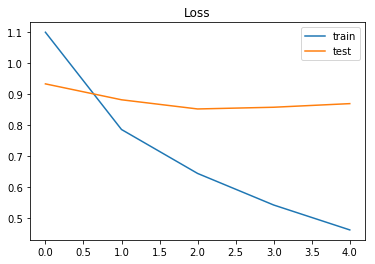

In [30]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

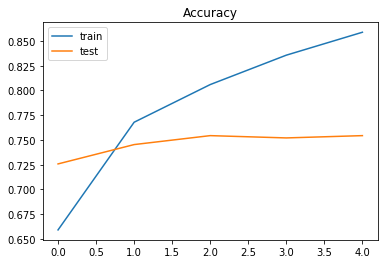

In [31]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

Test with a new complaint.